# ph_dos de PbF2

Dans ce notebook, nous étudions les états de phonons, la température de Debye et d'Einstein et les chaleurs spécifiques du PbF2

# Téléchargement de la densité d'états de phonons

In [26]:
import numpy as np
from mp_api.client import MPRester
from pymatgen.phonon.plotter import PhononBSPlotter
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import scipy.optimize as opt
import matplotlib.pyplot as plt
import scipy
import math

In [3]:
with MPRester("rxafJw6hy0L68C4ZGJP1j4UXfbE4nmS8") as m: 
    el_dos = m.get_dos_by_material_id("mp-315")
    ph_bs = m.get_phonon_bandstructure_by_material_id("mp-315")
    ph_dos = m.get_phonon_dos_by_material_id("mp-315")
    prim_struct = m.get_structure_by_material_id("mp-315")

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving PhononBSDOSDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving PhononBSDOSDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

# Calcul des températures de Debye et d'Einstein

1. Calcul de la chaleur spécifique

In [4]:
Temp = np.arange(0,1000,5) #températures
Na = len(prim_struct)  #nombre d'avogadro
R = 8.314 #constante des gaz parfaits
CV = np.array([ph_dos.cv(Temp[i]) for i in range(len(Temp))]) / (3 * Na * R)  #chaleurs spécifiques expérimentales

2. Calcul des températures de Debye et d'Einstein

In [21]:
def CV_Debye(Theta_D, Temp): #chaleur spécifique selon le modèle de Debye
    a = np.linspace(0.0001, Theta_D/Temp, 50) 
    b = (a**4 * np.exp(a)) / (np.exp(a) - 1)**2
    CV_D = 3 * (Temp / Theta_D)**3 * np.trapz(b,a)
    if math.isnan(CV_D):  
        CV_D = 0
    return CV_D

    

def CV_Einstein(Theta_E, Temp): #chaleur spécifique selon le modèle d'Einstein
    e= np.exp(Theta_E/Temp)
    CV_E = (Theta_E / Temp)**2 * e / (e - 1)**2
    if math.isnan(CV_E):
        CV_E= 0
    return CV_E

#calcul du theta optimal qui minimise l'erreur au sens des moindres carrés sur l'ensemble de la courbe de la chaleur spécifique.
def theta_opt(theta_teste, Temp, CV, mod): 
    result_theta = np.zeros(len(theta_teste))
    for j in range(len(theta_teste)):
        for i in range(len(Temp)):
            result_theta[j] += (CV[i] - mod(theta_teste[j], Temp[i]))**2
    return theta_teste[np.argmin(result_theta)]

Theta_teste_E = np.arange(150,250, 0.1)
Theta_teste_D = np.arange(250,350, 0.1)
theta_einstein = theta_opt(Theta_teste_E, Temp, CV, CV_Einstein) 
theta_debye = theta_opt(Theta_teste_D, Temp, CV, CV_Debye) 
print("La température d'Einstein est ",theta_einstein, "\nLa température de Debye est ", theta_debye  )

/tmp/ipykernel_2657807/4047245776.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  e= np.exp(Theta_E/Temp)
/tmp/ipykernel_2657807/4047245776.py:13: RuntimeWarning: divide by zero encountered in scalar divide
  CV_E = (Theta_E / Temp)**2 * e / (e - 1)**2
/tmp/ipykernel_2657807/4047245776.py:13: RuntimeWarning: invalid value encountered in scalar divide
  CV_E = (Theta_E / Temp)**2 * e / (e - 1)**2
/tmp/ipykernel_2657807/4047245776.py:2: RuntimeWarning: divide by zero encountered in scalar divide
  a = np.linspace(0.0001, Theta_D/Temp, 50)
/tmp/ipykernel_2657807/4047245776.py:3: RuntimeWarning: invalid value encountered in divide
  b = (a**4 * np.exp(a)) / (np.exp(a) - 1)**2


La température d'Einstein est  207.69999999999672 
La température de Debye est  281.5999999999982


# Représentation des trois courbes de chaleur spécifique

1. Calcul des chaleurs spécifiques selon le modelèe d'Einstein et de Debye

In [24]:
cv_einstein = np.zeros(len(Temp))
cv_debye = np.zeros(len(Temp))
for i in range(len(Temp)):
    cv_einstein[i] = CV_Einstein(theta_einstein, Temp[i])
    cv_debye[i] = CV_Debye(theta_debye, Temp[i])

/tmp/ipykernel_2657807/4047245776.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  e= np.exp(Theta_E/Temp)
/tmp/ipykernel_2657807/4047245776.py:13: RuntimeWarning: divide by zero encountered in scalar divide
  CV_E = (Theta_E / Temp)**2 * e / (e - 1)**2
/tmp/ipykernel_2657807/4047245776.py:13: RuntimeWarning: invalid value encountered in scalar divide
  CV_E = (Theta_E / Temp)**2 * e / (e - 1)**2
/tmp/ipykernel_2657807/4047245776.py:2: RuntimeWarning: divide by zero encountered in scalar divide
  a = np.linspace(0.0001, Theta_D/Temp, 50)
/tmp/ipykernel_2657807/4047245776.py:3: RuntimeWarning: invalid value encountered in divide
  b = (a**4 * np.exp(a)) / (np.exp(a) - 1)**2


2. Représentation des trois courbes de chaleur spécifique 

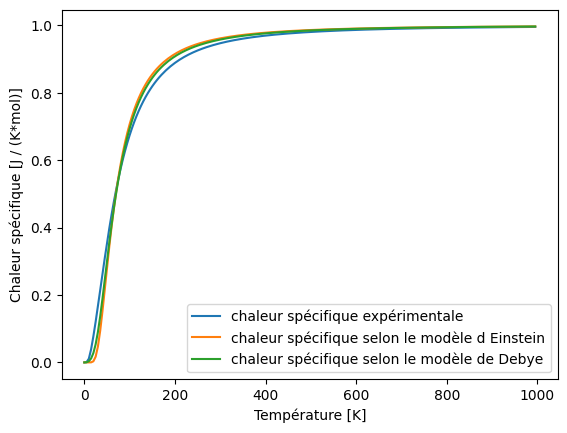

In [27]:
plt.plot(Temp, CV, label = 'chaleur spécifique expérimentale')
plt.plot(Temp, cv_einstein, label = 'chaleur spécifique selon le modèle d Einstein')
plt.plot(Temp, cv_debye, label = 'chaleur spécifique selon le modèle de Debye')
plt.xlabel("Température [K]")
plt.ylabel("Chaleur spécifique [J / (K*mol)]")
plt.legend()
plt.show()


# Représentation des trois densités d'états de phonons correspondantes aux chaleurs spécifiques ci-dessus

1. Récupération des fréquences et des densités d'états de phonons expérimentales

In [32]:
freq = ph_dos.frequencies
dens = ph_dos.densities

2. Calcul de la fréquence de Debye et d'Einstein et de la densité d'états de phonons correspondante à la chaleur spécifique selon le modèle de Debye. ( La densité d'états de phonons correspondante à la chaleur spécifique selon le modèle d'Einstein est simplement un delta de Dirac).

In [33]:
boltz = 1.3806485 * 10**(-23) #constante de Boltzmann
hbar = 6.6260702 * 10**(-34) #constante de Planck

freq_d = theta_debye * boltz / hbar / 10**12
freq_e = theta_einstein * boltz / hbar / 10**12

dos_d = np.zeros(len(freq))
for j in range(len(freq)):
    if freq[j] < freq_d:
        dos_d[j] = 9 * Na * freq[j]**2 / (2 * np.pi * freq_d**3)

3. Représentation des trois densités d'états de phonons

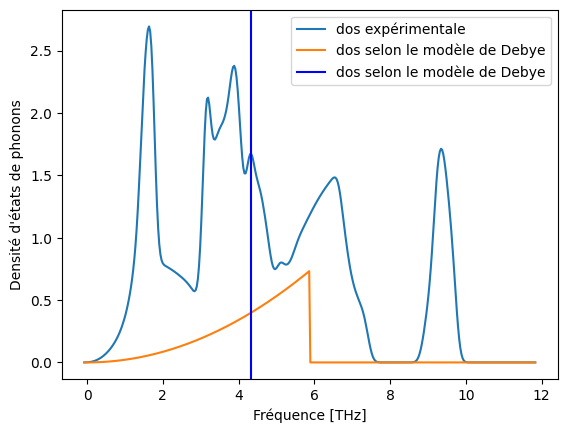

In [36]:
plt.plot(freq, dens, label = 'dos expérimentale')
plt.plot(freq, dos_d, label = 'dos selon le modèle de Debye')
plt.axvline(x = freq_e, color = "b", label= 'dos selon le modèle de Debye')
plt.xlabel("Fréquence [THz]")
plt.ylabel("Densité d'états de phonons")
plt.legend()
plt.show()